In [1]:
import sys
sys.path.append('C:/Users/rohan/Documents/Projects/Food_Demand_Forecasting_Challenge/Food_Demand_Forecasting_Challenge')

# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
%matplotlib inline
color = sns.color_palette()

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load original train data file
original_train_data = pd.read_csv(r'../data/raw/train_GzS76OK/train.csv')
meal_data = pd.read_csv(r'../data/raw/train_GzS76OK/meal_info.csv')
centers_data = pd.read_csv(r'../data/raw/train_GzS76OK/fulfilment_center_info.csv')

# Load original train data file
original_test_data = pd.read_csv(r'../data/raw/test_QoiMO9B.csv')

In [4]:
# Merge orders train data with meal and center data
full_original_train_data = pd.merge(original_train_data, meal_data, on='meal_id', how='left')
full_original_train_data = pd.merge(full_original_train_data, centers_data, on='center_id', how='left')

# Merge orders test data with meal and center data
full_original_test_data = pd.merge(original_test_data, meal_data, on='meal_id', how='left')
full_original_test_data = pd.merge(full_original_test_data, centers_data, on='center_id', how='left')

In [5]:
print('The original train data has {} observations and {} variables'.format(full_original_train_data.shape[0], full_original_train_data.shape[1]))
print('The original test data has {} observations and {} variables'.format(full_original_test_data.shape[0], full_original_test_data.shape[1]))

The original train data has 456548 observations and 15 variables
The original test data has 32573 observations and 14 variables


In [6]:
full_original_train_data.shape[1]

15

In [7]:
full_original_train_data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian,647,56,TYPE_C,2.0


In [8]:
full_original_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 15 columns):
id                       456548 non-null int64
week                     456548 non-null int64
center_id                456548 non-null int64
meal_id                  456548 non-null int64
checkout_price           456548 non-null float64
base_price               456548 non-null float64
emailer_for_promotion    456548 non-null int64
homepage_featured        456548 non-null int64
num_orders               456548 non-null int64
category                 456548 non-null object
cuisine                  456548 non-null object
city_code                456548 non-null int64
region_code              456548 non-null int64
center_type              456548 non-null object
op_area                  456548 non-null float64
dtypes: float64(3), int64(9), object(3)
memory usage: 55.7+ MB


In [9]:
full_original_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32573 entries, 0 to 32572
Data columns (total 14 columns):
id                       32573 non-null int64
week                     32573 non-null int64
center_id                32573 non-null int64
meal_id                  32573 non-null int64
checkout_price           32573 non-null float64
base_price               32573 non-null float64
emailer_for_promotion    32573 non-null int64
homepage_featured        32573 non-null int64
category                 32573 non-null object
cuisine                  32573 non-null object
city_code                32573 non-null int64
region_code              32573 non-null int64
center_type              32573 non-null object
op_area                  32573 non-null float64
dtypes: float64(3), int64(8), object(3)
memory usage: 3.7+ MB


In [10]:
# Compute the number of unique meals
meal_list = np.sort(full_original_train_data['meal_id'].unique())
print('There are {} unique meals served'.format(len(meal_list)))

There are 51 unique meals served


In [11]:
# Compute the number of unique centers
center_list = np.sort(full_original_train_data['center_id'].unique())
print('There are {} unique centers'.format(len(center_list)))

There are 77 unique centers


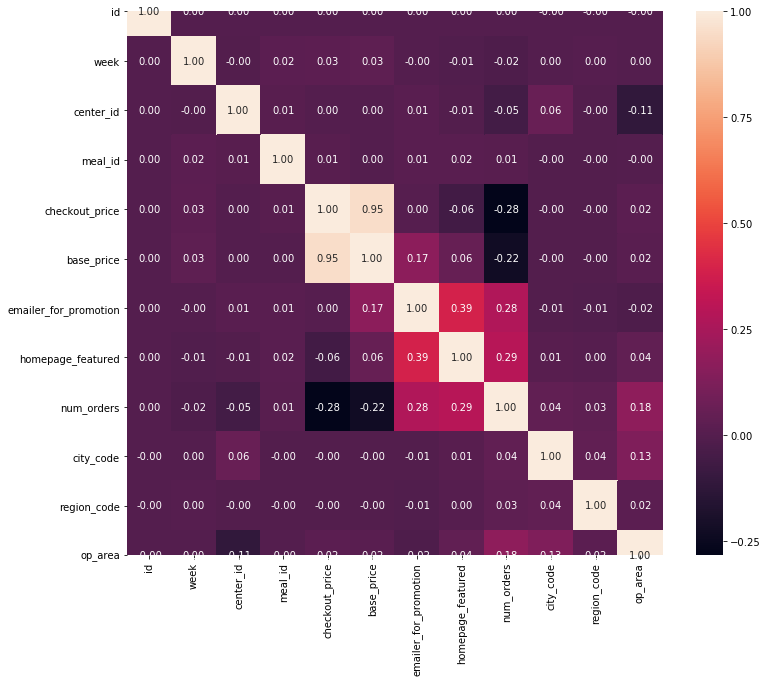

In [12]:
# Plot the linear correlation between different numerical features
plt.figure(figsize=(12,10))
corr = full_original_train_data.corr()
sns.heatmap(corr,annot=True, fmt='.2f')

* There's an almost perfect positive correlation between checkout_price and base price, which is as expected.
* More interestingly, there's a noticeable positive correlation between `emailers_for_promotion` and `num_of_orders`.
* There's also a noticeable positive correlation between `homepage_featured` and `num_of_orders`.
* Again, as expected, there's a noticeable negative correlation between `checkout_price` and `num_of_orders` and a similar correlation between `base_price` and `num_of_orders`.
* There's a positive correlation between `op_area` and `num_of_orders` which corroborates the logic, higher the operating area of a center, larger the customer base the center caters to and hence larger the number of orders placed at the center

### Build Our Data
The whole data has 456548 rows, it consists of data for 145 weeks. Let's train our predictive models on data for the `first 130 weeks (week 1 to week 130)`, then validate our models for the `next 10 weeks (from week 131 to week 140)` and then finally test our model on the `last 5 weeks (week 141 to week 145)`. 

In [13]:
# SLice the full original train data into three sets: train, validation and test set

train = full_original_train_data[full_original_train_data['week'] <= 130].copy()
val   = full_original_train_data[(full_original_train_data['week'] >= 131) & (full_original_train_data['week'] <= 140)].copy()
test  = full_original_train_data[(full_original_train_data['week'] >= 141) & (full_original_train_data['week'] <= 145)].copy()

In [14]:
print('Train dataset has {} observations'.format(train.shape[0]))
print('Validation dataset has {} observations'.format(val.shape[0]))
print('Test dataset has {} observations'.format(test.shape[0]))

Train dataset has 407243 observations
Validation dataset has 32929 observations
Test dataset has 16376 observations


In [15]:
# Save the datasets to disk
train.to_csv(r'../data/interim/train_data.csv', index=False)
val.to_csv(r'../data/interim/val_data.csv', index=False)
test.to_csv(r'../data/interim/test_data.csv', index=False)

full_original_train_data.to_csv(r'../data/interim/full_original_train_data.csv', index=False)
full_original_test_data.to_csv(r'../data/interim/full_original_test_data.csv', index=False)

### Visualize The Data
Let's visualize each of the features against our target variable

In [15]:
# Plot the relation between checkout price and number of orders
(p9.ggplot(data=train_data,
           mapping=p9.aes(x='checkout_price', y='num_orders'))
+ p9.geom_jitter(alpha=0.2)
+ p9.scales.scale_color_cmap(name='viridis'));

NameError: name 'train_data' is not defined

* There's a steady decline in Number of Orders (num_orders) with increase in Checkout Price (checkout_price).

In [ ]:
# Plot the relation between margin and number of orders
train_data['discount'] = train_data['base_price'] - train_data['checkout_price']

train_data = train_data[train_data['num_orders'] < 15000]

(p9.ggplot(data=train_data,
           mapping=p9.aes(x='discount', y='num_orders'))
+ p9.geom_jitter(alpha=0.2));

In [ ]:
# Plot the relation between Center Type and Number of Orders
(p9.ggplot(data=train_data,
           mapping=p9.aes(x='center_type', y='num_orders'))
+ p9.geom_bar(stat='identity'));

Type A centers have by far the most number of orders. This could be because Type_A has more centers in it. Let's dig into this deeper.

In [ ]:
# Take a snapshot of all centers and their types
week_34_meal_1885 = train_data[(train_data['week'] == 34) & (train_data['meal_id'] == 1885)]
centers_and_types = week_34_meal_1885[['center_id','center_type']]
center_type_counts = centers_and_types.groupby(['center_type'])['center_id'].count().reset_index(name='type_count')

# Plot the number of centers in each type
(p9.ggplot(data=center_type_counts,
           mapping=p9.aes(x='center_type', y='type_count'))
+ p9.geom_bar(stat='identity', position='dodge'));

Thus, we can see  that TYPE_A has more than double the number of centers when compared to TYPE_B or TYPE_C. And that partly explains the reason why TYPE_A centers have more number of orders.

In [ ]:
# Plot Number of Orders by Operating Area of the Center
(p9.ggplot(data=train_data[train_data['num_orders'] < 10000],
           mapping=p9.aes(x='factor(op_area)', y='num_orders'))
+ p9.geom_jitter(alpha=0.2)
+ p9.theme(axis_text_x=p9.element_text(angle=90)));

There's a steady increase in number of orders as operating area increases.

In [ ]:
# Plot Number of Orders By Cuisine
(p9.ggplot(data=train_data,
           mapping=p9.aes(x='cuisine', y='num_orders', color='cuisine'))
+ p9.geom_bar(stat='identity')
+ p9.theme(axis_text_x=p9.element_text(angle=90)));

Italian cuisine has the greatest demand followed by Thai.

In [ ]:
# Plot Number of Orders By Category
(p9.ggplot(data=train_data,
           mapping=p9.aes(x='category', y='num_orders'))
+ p9.geom_bar(stat='identity')
+ p9.theme(axis_text_x=p9.element_text(angle=90)));

The most popular category by far is Beverages. Rice Bowl is the second most popular closely followed by Sandwich.

In [ ]:
# Plot Number of Orders By Category for Italian Cuisine

italian_data = train_data[train_data['cuisine'] == 'Italian']
(p9.ggplot(data=italian_data,
           mapping=p9.aes(x='category', y='num_orders'))
+ p9.geom_bar(stat='identity')
+ p9.theme(axis_text_x=p9.element_text(angle=90))
+ p9.labs(title='Number of Orders by Category for Italian Cuisine'));

In Italian Cuisine, surprisingly, Sandwich is more popular compared to Beverages.

In [ ]:
# Plot Number of Orders By Category for Thai Cuisine
thai_data = train_data[train_data['cuisine'] == 'Thai']

(p9.ggplot(data=thai_data,
           mapping=p9.aes(x='category', y='num_orders'))
+ p9.geom_bar(stat='identity')
+ p9.theme(axis_text_x=p9.element_text(angle=90))
+ p9.labs(title='Number of Orders by Category for Thai Cuisine'));

In Thai Cuisine, Beverages are by far the most popular.

In [ ]:
# Plot Number of Orders By Category for Indian Cuisine
indian_data = train_data[train_data['cuisine'] == 'Indian']

(p9.ggplot(data=indian_data,
           mapping=p9.aes(x='category', y='num_orders'))
+ p9.geom_bar(stat='identity')
+ p9.theme(axis_text_x=p9.element_text(angle=90))
+ p9.labs(title='Number of Orders by Category for Indian Cuisine'));

In Indian cuisine, Rice Bowl is by far the most popular.

In [ ]:
# Plot Number of Orders By Category for Continental Cuisine
continental_data = train_data[train_data['cuisine'] == 'Continental']

(p9.ggplot(data=continental_data,
           mapping=p9.aes(x='category', y='num_orders'))
+ p9.geom_bar(stat='identity')
+ p9.theme(axis_text_x=p9.element_text(angle=90))
+ p9.labs(title='Number of Orders by Category for Continental Cuisine'));

In Continental cuisine, Beverages are the most popular closely followed by PIzza.

In [ ]:
# Plot Number of Orders By Cuisine for Beverages Category
beverages_data = train_data[train_data['category'] == 'Beverages']

(p9.ggplot(data=beverages_data,
           mapping=p9.aes(x='cuisine', y='num_orders'))
+ p9.geom_bar(stat='identity')
+ p9.theme(axis_text_x=p9.element_text(angle=90))
+ p9.labs(title='Number of Orders By Cuisine for Beverages Category'));

Among Beverages category, Thai beverages are the most popular, followed by Italian.

In [ ]:
# Plot Number of Orders Against Whether or not Promotional Emails were sent out 
(p9.ggplot(data=train_data,
           mapping=p9.aes(x='emailer_for_promotion', y='num_orders'))
+ p9.geom_bar(stat='identity')
+ p9.theme(axis_text_x=p9.element_text(angle=90))
+ p9.labs(title='Number of Orders By Promotional Emailers'));

In [ ]:
# Plot Number of Orders Against Whether or not meal featured on Homepage
(p9.ggplot(data=train_data,
           mapping=p9.aes(x='homepage_featured', y='num_orders'))
+ p9.geom_bar(stat='identity')
+ p9.theme(axis_text_x=p9.element_text(angle=90))
+ p9.labs(title='Number of Orders By Homepage Featured'));

In [ ]:
# Plot Number of Orders Vs Promotional Emailers Vs Category 
(p9.ggplot(data=train_data,
           mapping=p9.aes(x='factor(checkout_price)', y='num_orders', color='emailer_for_promotion'))
+ p9.geom_violin()
+ p9.theme(axis_text_x=p9.element_text(angle=90))
+ p9.labs(title='Number of Orders Vs Checkout Price Vs Promotional Emailers'));

In [ ]:
# Plot Number of Orders By Cuisine
(p9.ggplot(data=full_data,
           mapping=p9.aes(x='cuisine', y='num_orders', color='cuisine'))
+ p9.geom_bar(stat='identity')
+ p9.theme(axis_text_x=p9.element_text(angle=90)));

In [ ]:
# Plot Number of Orders By Category
(p9.ggplot(data=full_data,
           mapping=p9.aes(x='category', y='num_orders'))
+ p9.geom_bar(stat='identity')
+ p9.theme(axis_text_x=p9.element_text(angle=90)));